# Описание проекта

**Описание проекта:** Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей которые готовы совершить покупку в ближайшее время.
Предоставлены данные по истории покупателей. Есть история реакции клиента на преведенные коммуникации. Коммуникация это - промо-предложение, направленное в смс / push сообщении, или электронной почте. По каждому товару проставлена категория, которая помогает определить насколько покупатель “латентен” (предпочтителен) к этой группе товаров.<br>

**Цель** -  создать модель прогнозирования покупки каждым покупателем в ближайшие 90 дней. Это нужно для улучшения работы и повышения эффективности марктетинговых компаний.<br>

**Описание данных:**<br>
* `apparel-purchases` - Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук. В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам. Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например (4, 28, 44, 1594) или (4, 44, 1594). Необходимо обработать такие случаи.
    * client_id - идентификатор клиента
    * quantity - количество единиц товара
    * price - цена товара
    * category_ids - идентификаторы категорий
    * date - дата покупки
    * message_id - идентификатор сообщения из рассылки<br><br>
    
* `apparel-messages` - Рассылки, которые были отправлены клиентам из таблицы покупок.<br>
    * `bulk_campaign_id` - идентификатор рассылки
    * `client_id` - идентификатор клиента
    * `message_id` - идентификатор сообщения
    * `event` - действие с сообщением (отправлено, открыто, покупка…)
    * `channel` - канал рассылки
    * `date` - дата действия
    * `created_at` - дата-время полностью<br><br>
    
* target - Целевой признак
    * `client_id` - идентификатор клиента
    * `target` - клиент совершил покупку в целевом периоде<br><br>
    
* full_campaign_daily_event - Агрегация общей базы рассылок по дням и типам событий
    * `date` - дата
    * `bulk_campaign_id` - идентификатор рассылки
    * `count_event` - общее количество каждого события event
    * `nunique_event` - количество уникальных client_id в каждом событии. В именах колонок найдете все типы событий `event`.<br><br>
* full_campaign_daily_event_channel - Агрегация по дням с учетом событий и каналов рассылки
    * `date` - дата
    * `bulk_campaign_id` - идентификатор рассылки
    * `count_event*_channel` - общее количество каждого события по каналам
    * `nunique_event*_channel` - количество уникальных client_id по событиям и каналам. D именах колонок есть все типы событий event и каналов рассылки `channel`.

# Импорт библиотек

In [1]:
import warnings, os, ast, json, time
warnings.filterwarnings("ignore")
import importlib.metadata as md

# === Базовые библиотеки ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Метрики и валидация ===
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    fbeta_score
)

# === Предобработка ===
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# === Балансировка ===
from imblearn.over_sampling import SMOTE

# === Модели ===
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# === Интерпретация и корреляции ===
import phik
from phik.report import plot_correlation_matrix
import shap

# === Настройки визуализации ===
sns.set_theme(style="whitegrid", palette="muted")
pd.set_option("display.max_columns", None)


In [2]:
libs = ["pandas","numpy","matplotlib","seaborn","scikit-learn","xgboost","lightgbm","catboost","phik","shap","imbalanced-learn"]
versions = {lib: md.version(lib if lib!="scikit-learn" else "scikit-learn") for lib in libs}
print(json.dumps(versions, indent=2, ensure_ascii=False))

{
  "pandas": "2.3.2",
  "numpy": "1.24.4",
  "matplotlib": "3.10.6",
  "seaborn": "0.13.2",
  "scikit-learn": "1.4.2",
  "xgboost": "2.1.4",
  "lightgbm": "4.6.0",
  "catboost": "1.2.7",
  "phik": "0.12.5",
  "shap": "0.48.0",
  "imbalanced-learn": "0.11.0"
}


In [3]:
#  Константы
RANDOM_STATE = 42
N_JOBS = -1
CV_SPLITS = 3
TEST_SIZE = 0.25
np.random.seed(RANDOM_STATE)

In [4]:
M1, M2 = "apparel-messages.csv", "/datasets/apparel-messages.csv"
P1, P2 = "apparel-purchases.csv", "/datasets/apparel-purchases.csv"
T1, T2 = "apparel-target_binary.csv", "/datasets/apparel-target_binary.csv"
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

## Вспомогательные утилиты

In [5]:
def most_freq(s: pd.Series, default="0"):
    m = s.mode()
    return m.iloc[0] if not m.empty else default

def show_info(df: pd.DataFrame, name: str = "DataFrame", n=5):
    print(f"=== {name} ===")
    display(df.head(n))
    print("shape:", df.shape)
    print("nulls:\n", df.isna().sum())
    # безопасный duplicated: исключаем не-хэшируемые колонки (list, dict, np.ndarray)
    safe_cols = []
    for c in df.columns:
        try:
            hash(df[c].iloc[0])
            safe_cols.append(c)
        except Exception:
            pass
    try:
        print("dups:", df.duplicated(subset=safe_cols).sum())
    except Exception as e:
        print("dups: skipped ->", e)
    display(df.describe(include="all"))

def timer(msg=""):
    t0 = time.time()
    def done():
        print(f"[{msg}] {time.time()-t0:.2f}s")
    return done

## Загрузка данных

In [6]:
def load_df(pth1, pth2, parse_dates=None):
    if os.path.exists(pth1):
        return pd.read_csv(pth1, parse_dates=parse_dates)
    if os.path.exists(pth2):
        return pd.read_csv(pth2, parse_dates=parse_dates)
    raise FileNotFoundError(f"Файл не найден: {pth1} или {pth2}")

In [7]:
df_messages = load_df(M1, M2, parse_dates=["date","created_at"])
df_purchases = load_df(P1, P2, parse_dates=["date"])
df_target    = load_df(T1, T2)
show_info(df_messages, "Messages (raw)")
show_info(df_purchases, "Purchases (raw)")
show_info(df_target, "Target (raw)")

=== Messages (raw) ===


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


shape: (12739798, 7)
nulls:
 bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64
dups: 48610


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798,12739798,12739798,12739798
unique,NaN,NaN,9061667,11,2,NaN,NaN
top,NaN,NaN,1515915625489095763-6251-6311b13a4cf78,send,mobile_push,NaN,NaN
freq,NaN,NaN,1454,9058196,7512156,NaN,NaN
mean,1.160459e+04,1.515916e+18,NaN,NaN,NaN,2023-06-05 02:46:08.357990400,2023-06-05 13:58:11.168689408
min,5.480000e+02,1.515916e+18,NaN,NaN,NaN,2022-05-19 00:00:00,2022-05-19 00:14:20
25%,8.746000e+03,1.515916e+18,NaN,NaN,NaN,2022-12-19 00:00:00,2022-12-19 12:46:30
50%,1.351600e+04,1.515916e+18,NaN,NaN,NaN,2023-07-20 00:00:00,2023-07-20 17:21:54
75%,1.415800e+04,1.515916e+18,NaN,NaN,NaN,2023-11-21 00:00:00,2023-11-21 18:13:05
max,1.465700e+04,1.515916e+18,NaN,NaN,NaN,2024-02-15 00:00:00,2024-02-15 23:58:40


=== Purchases (raw) ===


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


shape: (202208, 6)
nulls:
 client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64
dups: 73020


,client_id,quantity,price,category_ids,date,message_id
count,2.022080e+05,202208.000000,202208.000000,202208,202208,202208
unique,NaN,NaN,NaN,933,NaN,50204
top,NaN,NaN,NaN,"['4', '28', '57', '431']",NaN,1515915625489095763-6251-6311b13a4cf78
freq,NaN,NaN,NaN,8626,NaN,365
mean,1.515916e+18,1.006483,1193.301516,NaN,2023-03-17 02:49:35.739832064,NaN
min,1.515916e+18,1.000000,1.000000,NaN,2022-05-16 00:00:00,NaN
25%,1.515916e+18,1.000000,352.000000,NaN,2022-11-12 00:00:00,NaN
50%,1.515916e+18,1.000000,987.000000,NaN,2023-04-12 00:00:00,NaN
75%,1.515916e+18,1.000000,1699.000000,NaN,2023-07-03 00:00:00,NaN
max,1.515916e+18,30.000000,85499.000000,NaN,2024-02-16 00:00:00,NaN


=== Target (raw) ===


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


shape: (49849, 2)
nulls:
 client_id    0
target       0
dtype: int64
dups: 0


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


## Предобработка и удаление дубликатов

In [8]:
df_messages = df_messages.drop_duplicates().copy()
if "created_at" in df_messages.columns:
    df_messages = df_messages.drop(columns=["created_at"])
df_purchases = df_purchases.drop_duplicates().copy()
df_target    = df_target.drop_duplicates().copy()

In [9]:
clients_m = set(df_messages["client_id"].unique())
clients_p = set(df_purchases["client_id"].unique())
clients_t = set(df_target["client_id"].unique())

print("targets not in purchases:", len(clients_t - clients_p))
print("purchases not in messages:", len(clients_p - clients_m))
print("messages not in purchases:", len(clients_m - clients_p))

msg_in_p = set(df_purchases["message_id"].unique())
msg_in_m = set(df_messages["message_id"].unique())
print("message_id in purchases not in messages:", len(msg_in_p - msg_in_m))
print("message_id in messages not in purchases:", len(msg_in_m - msg_in_p))

targets not in purchases: 0
purchases not in messages: 7867
messages not in purchases: 11347
message_id in purchases not in messages: 394
message_id in messages not in purchases: 9011857


1. **Target ⊆ Purchases**  
   Все клиенты из целевой выборки (`target`) присутствуют в данных о покупках (`purchases`).  
   Это корректно, так как целевой признак основан на факте покупки.  

2. **Purchases ⊄ Messages**  
   Часть клиентов совершала покупки, но по ним отсутствуют записи в таблице сообщений (`messages`).  
   Возможные причины:  
   - неполные данные о коммуникациях;  
   - покупка без взаимодействия с сообщениями (например, прямой визит).  

3. **Messages ≫ Purchases**  
   Объём сообщений значительно превышает количество покупок.  
   Это ожидаемо: большинство сообщений не приводят к покупке, что отражает реальное клиентское поведение.  


-  чистка дублей в df_messages

- Проверяем дубликаты по комбинации колонок:
  - `message_id`
  - `event`
  - `channel`
  - `client_id`

- Удаляем строки, которые повторяются полностью по этим 4 признакам.

- После очистки остаётся только **уникальная запись** для каждой комбинации  
  (`message_id`, `event`, `channel`, `client_id`).

То есть убираем ситуации, когда одно и то же событие одного и того же сообщения
от одного клиента по одному каналу записано несколько раз.

In [10]:
dup_count_before = df_messages.duplicated(
    subset=["message_id","event","channel","client_id"],
    keep=False
).sum()

print(f"Дубликатов перед очисткой: {dup_count_before}")

# Удаляем дубли
df_messages = df_messages.drop_duplicates(
    subset=["message_id","event","channel","client_id"]
).copy()

# Проверяем, что осталось
dup_count_after = df_messages.duplicated(
    subset=["message_id","event","channel","client_id"],
    keep=False
).sum()

print(f"Дубликатов после очистки: {dup_count_after}")
print(f"Осталось строк в df_messages: {len(df_messages):,}")

Дубликатов перед очисткой: 479854
Дубликатов после очистки: 0
Осталось строк в df_messages: 12,401,356


In [11]:
# Ячейка 9 — Проверка диапазонов дат
print("Purchases date min/max:", df_purchases["date"].min(), df_purchases["date"].max())
print("Messages  date min/max:", df_messages["date"].min(),  df_messages["date"].max())

Purchases date min/max: 2022-05-16 00:00:00 2024-02-16 00:00:00
Messages  date min/max: 2022-05-19 00:00:00 2024-02-15 00:00:00


## Обработка категорий товаров в чеках и формирование признаков

In [12]:
df_purchases["category_ids"] = (
    df_purchases["category_ids"]
    .astype(str)
    .str.strip("[] ")
    .str.replace("'", "")  
    .str.split(",") 
)

# считаем длину списков
df_purchases["cat_len"] = df_purchases["category_ids"].apply(len)

print(df_purchases["cat_len"].describe())
print("Максимум категорий в одном чеке:", df_purchases["cat_len"].max())

# примеры "длинных" чеков
print(df_purchases[df_purchases["cat_len"] > 3]["category_ids"].head(10))

count    129188.000000
mean          3.918948
std           0.485672
min           1.000000
25%           4.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: cat_len, dtype: float64
Максимум категорий в одном чеке: 5
0           [4,  28,  57,  431]
1           [4,  28,  57,  431]
2           [4,  28,  57,  431]
3          [4,  28,  244,  432]
4           [4,  28,  49,  413]
5          [2,  18,  258,  441]
6         [2,  18,  341,  1311]
7          [2,  18,  123,  451]
8    [5562,  5631,  5549,  667]
9    [5562,  5630,  5649,  678]
Name: category_ids, dtype: object


In [13]:
def _to_list(x):
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(x)
    except Exception:
        return []
df_purchases["category_ids"] = df_purchases["category_ids"].apply(_to_list)
df_purchases[["cat1","cat2","cat3","cat4","cat5"]] = pd.DataFrame(
    df_purchases["category_ids"].apply(lambda x: (x+["0"]*5)[:5]).to_list(),
    index=df_purchases.index
)
# сразу убираем список, чтобы не ломать duplicated/EDA
df_purchases = df_purchases.drop(columns=["category_ids"])

In [14]:
# Просмотр после очистки
show_info(df_messages, "Messages (clean)")
show_info(df_purchases, "Purchases (clean)")
show_info(df_target,    "Target (clean)")

=== Messages (clean) ===


,bulk_campaign_id,client_id,message_id,event,channel,date
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19


shape: (12401356, 6)
nulls:
 bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
dtype: int64
dups: 0


,bulk_campaign_id,client_id,message_id,event,channel,date
count,1.240136e+07,1.240136e+07,12401356,12401356,12401356,12401356
unique,NaN,NaN,9061667,11,2,NaN
top,NaN,NaN,1515915625588077337-6374-63241bb3c8b77,send,mobile_push,NaN
freq,NaN,NaN,6,9055427,7428574,NaN
mean,1.164809e+04,1.515916e+18,NaN,NaN,NaN,2023-06-07 10:10:07.996742400
min,5.480000e+02,1.515916e+18,NaN,NaN,NaN,2022-05-19 00:00:00
25%,8.902000e+03,1.515916e+18,NaN,NaN,NaN,2022-12-21 00:00:00
50%,1.353700e+04,1.515916e+18,NaN,NaN,NaN,2023-07-24 00:00:00
75%,1.416600e+04,1.515916e+18,NaN,NaN,NaN,2023-11-22 00:00:00
max,1.465700e+04,1.515916e+18,NaN,NaN,NaN,2024-02-15 00:00:00


=== Purchases (clean) ===


,client_id,quantity,price,date,message_id,cat_len,cat1,cat2,cat3,cat4,cat5
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,4,28,57,431,0
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,4,28,57,431,0
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,4,28,57,431,0
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,4,28,244,432,0
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,4,28,49,413,0


shape: (129188, 11)
nulls:
 client_id     0
quantity      0
price         0
date          0
message_id    0
cat_len       0
cat1          0
cat2          0
cat3          0
cat4          0
cat5          0
dtype: int64
dups: 0


,client_id,quantity,price,date,message_id,cat_len,cat1,cat2,cat3,cat4,cat5
count,1.291880e+05,129188.000000,129188.000000,129188,129188,129188.000000,129188,129188,129188,129188,129188
unique,NaN,NaN,NaN,NaN,50204,NaN,10,32,292,839,2
top,NaN,NaN,NaN,NaN,1515915625489095763-6251-6311b13a4cf78,NaN,4,28,57,431,0
freq,NaN,NaN,NaN,NaN,222,NaN,73428,53564,6191,6191,128843
mean,1.515916e+18,1.009420,1264.532766,2023-02-26 07:40:09.771805440,NaN,3.918948,NaN,NaN,NaN,NaN,NaN
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
25%,1.515916e+18,1.000000,399.000000,2022-09-09 00:00:00,NaN,4.000000,NaN,NaN,NaN,NaN,NaN
50%,1.515916e+18,1.000000,999.000000,2023-03-22 00:00:00,NaN,4.000000,NaN,NaN,NaN,NaN,NaN
75%,1.515916e+18,1.000000,1750.000000,2023-06-28 00:00:00,NaN,4.000000,NaN,NaN,NaN,NaN,NaN
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00,NaN,5.000000,NaN,NaN,NaN,NaN,NaN


=== Target (clean) ===


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


shape: (49849, 2)
nulls:
 client_id    0
target       0
dtype: int64
dups: 0


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


In [15]:
df_purchases["date"] = pd.to_datetime(df_purchases["date"])
df_purchases["revenue"] = df_purchases["quantity"] * df_purchases["price"]
max_date = df_purchases["date"].max()

# Флаг на уровне СТРОК (нужен для суммирования в purchases_agg)
df_purchases["count_buy_90"] = (df_purchases["date"] >= max_date - pd.Timedelta(days=90)).astype(int)

# Добавляем признак "разнообразие категорий" (как у коллег)
df_purchases['unique_categories'] = df_purchases[['cat1','cat2','cat3','cat4','cat5']].nunique(axis=1)

def most_freq(s: pd.Series):
    m = s.mode()
    return m.iloc[0] if not m.empty else np.nan

# агрегат
purchases_agg = df_purchases.groupby("client_id").agg(
    # Из вашего purchases_agg
    quantity_sum=("quantity", "sum"),
    revenue_sum=("revenue", "sum"),
    first_date=("date", "min"),
    last_date=("date", "max"),
    purchase_days=("date", lambda s: s.dt.date.nunique()),
    count_buy_90=("count_buy_90", "sum"),
    message_id_nunique=("message_id", "nunique"),
    cat1=("cat1", most_freq),
    cat2=("cat2", most_freq),
    cat3=("cat3", most_freq),
    cat4=("cat4", most_freq),
    cat5=("cat5", most_freq),
    
    # Из client_info_df
    purchase_count=("date", "count"),  # то же что и было в client_info_df
    total_category_diversity=("unique_categories", "sum"),  # новый признак разнообразия
    
).reset_index()

# Дополнительные расчеты 
purchases_agg["days_active"] = (purchases_agg["last_date"] - purchases_agg["first_date"]).dt.days
purchases_agg["days_since_last"] = (max_date - purchases_agg["last_date"]).dt.days
purchases_agg["avg_price"] = (
    purchases_agg["revenue_sum"] / purchases_agg["quantity_sum"].replace(0, np.nan)
).fillna(0.0)
purchases_agg["mean_purchase_period"] = (
    purchases_agg["days_active"] / purchases_agg["purchase_days"].replace(0, np.nan)
).fillna(purchases_agg["days_active"]).round().astype(int)

# Frequency encoding для категорий
def freq_encode(series: pd.Series):
    freq = series.value_counts().to_dict()
    return series.map(freq).fillna(0).astype(int), freq

enc_maps = {}
for col in ["cat1","cat2","cat3","cat4","cat5"]:
    purchases_agg[col+"_freq"], enc_maps[col] = freq_encode(purchases_agg[col])

purchases_agg = purchases_agg.drop(columns=["cat1","cat2","cat3","cat4","cat5"])

display(purchases_agg.head())
print(f"Итоговое количество клиентов: {len(purchases_agg)}")
print(f"Итоговое количество признаков: {len(purchases_agg.columns)}")

,client_id,quantity_sum,revenue_sum,first_date,last_date,purchase_days,count_buy_90,message_id_nunique,purchase_count,total_category_diversity,days_active,days_since_last,avg_price,mean_purchase_period,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq
0,1515915625468060902,5,4795.0,2022-05-27,2022-05-27,1,0,1,5,25,0,630,959.000000,0,30315,23992,127,88,49690
1,1515915625468061003,6,14135.0,2023-01-04,2023-01-04,1,0,1,6,30,0,408,2355.833333,0,30315,23992,1152,424,49690
2,1515915625468061099,1,299.0,2022-05-17,2022-05-17,1,0,1,1,5,0,640,299.000000,0,30315,23992,1358,270,49690
3,1515915625468061100,1,1049.0,2024-02-10,2024-02-10,1,1,1,1,5,0,6,1049.000000,0,30315,2469,452,13,49690
4,1515915625468061170,8,14102.0,2023-03-26,2023-06-17,3,0,3,8,37,83,244,1762.750000,28,30315,23992,2446,2160,49690


Итоговое количество клиентов: 49849
Итоговое количество признаков: 19


#  Формирование признаков по покупкам

Подготовка и базовые вычисления
- **date** — приведение поля к типу `datetime` для последующих расчётов.
- **revenue** — сумма покупки, вычисляется как `quantity × price`.
- **max_date** — максимальная дата в данных, используется для расчёта признаков "последние 90 дней".

Флаги и индивидуальные признаки
- **count_buy_90** — бинарный флаг: 1, если покупка была за последние 90 дней, 0 — иначе.
- **unique_categories** — число различных категорий `cat1..cat5` внутри одной покупки (оценка разнообразия товаров).

Агрегация по клиенту (`client_id`)
Создаётся единая таблица `purchases_agg` со следующими агрегатами:
- **quantity_sum** — общее количество купленных товаров.
- **revenue_sum** — суммарная выручка по всем покупкам.
- **first_date / last_date** — дата первой и последней покупки клиента.
- **purchase_days** — количество уникальных календарных дней с покупками.
- **count_buy_90** — количество покупок за последние 90 дней (сумма флагов).
- **message_id_nunique** — число уникальных сообщений, связанных с покупками.
- **cat1..cat5** — наиболее часто встречающаяся категория в каждой из позиций.
- **purchase_count** — общее количество покупок (строк клиента).
- **total_category_diversity** — суммарное разнообразие категорий по всем покупкам клиента.

Производные признаки по времени
- **days_active** — длительность покупательской активности клиента  
  *(разница между последней и первой покупкой, в днях)*.
- **days_since_last** — сколько дней прошло с момента последней покупки до `max_date`.
- **avg_price** — средняя цена товара клиента (`revenue_sum / quantity_sum`).
- **mean_purchase_period** — средний интервал между днями с покупками  
  *(отношение `days_active / purchase_days`, округлённое до целого числа)*.

Частотное кодирование категориальных признаков
Для категориальных признаков `cat1..cat5` выполняется frequency encoding:
- Для каждого признака создаются новые поля `cat1_freq` … `cat5_freq`,
  содержащие частоту встречаемости категории в наборе клиентов.
- Оригинальные `cat1..cat5` удаляются после кодирования.

Финальный результат
На выходе формируется таблица `purchases_agg`, содержащая:
- по одной строке на каждого клиента;
- агрегированные количественные, временные и категориальные признаки;

## Анализ клиентской активности

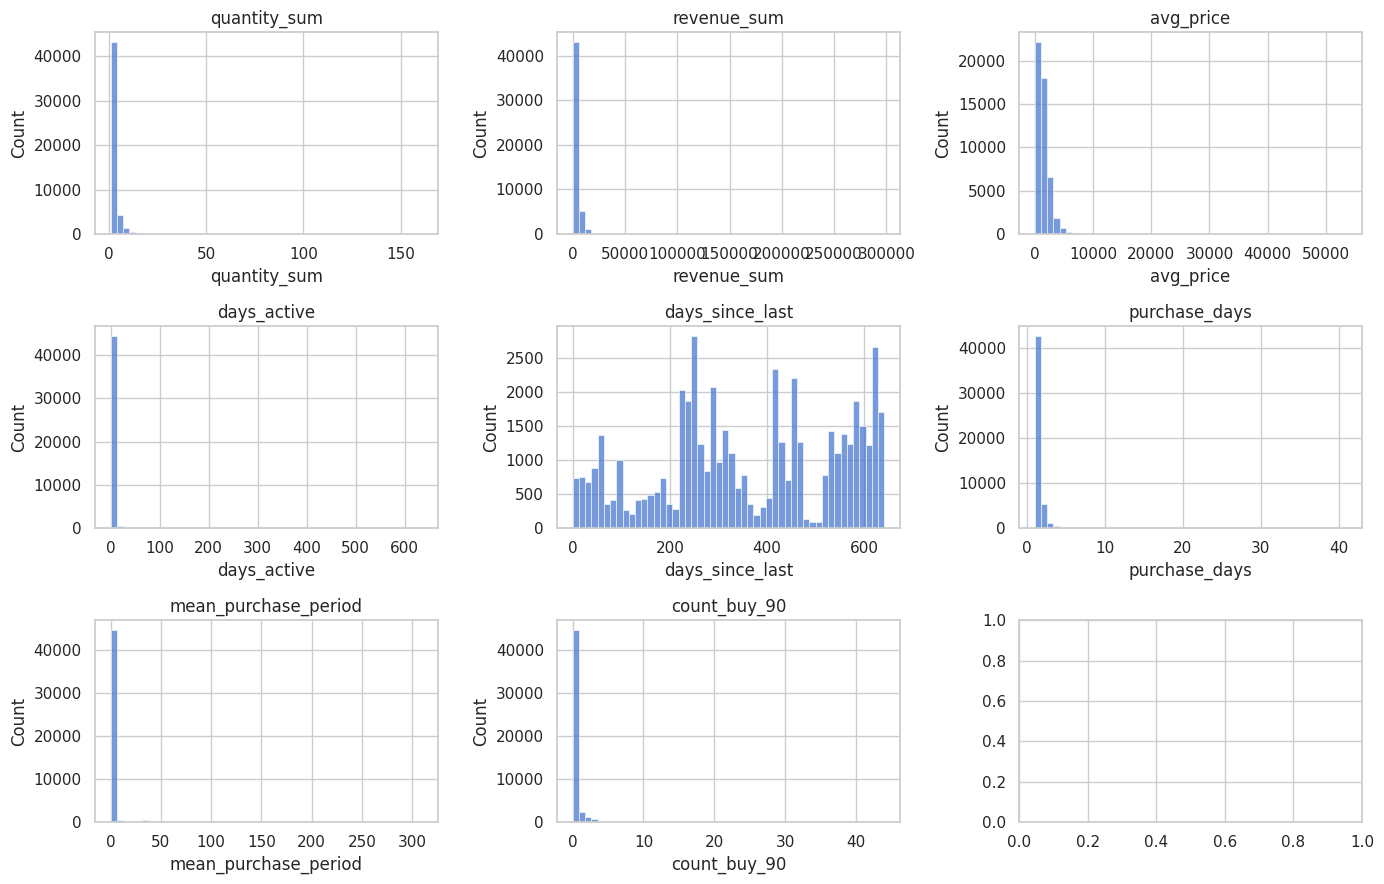

In [16]:
num_cols_quick = ["quantity_sum","revenue_sum","avg_price","days_active","days_since_last","purchase_days","mean_purchase_period","count_buy_90"]
fig, axes = plt.subplots(nrows=len(num_cols_quick)//3+1, ncols=3, figsize=(14, 3*((len(num_cols_quick)//3)+1)))
axes = axes.ravel()
for ax, col in zip(axes, num_cols_quick):
    if col in purchases_agg.columns:
        sns.histplot(purchases_agg[col], bins=50, ax=ax)
        ax.set_title(col)
plt.tight_layout()
plt.show()

# Признаки из покупок (`purchases_agg`)

В этом блоке анализируются и визуализируются признаки, рассчитанные по истории покупок каждого клиента.  
Основная цель — понять покупательское поведение и активность пользователей.

**Используемые признаки:**
- `quantity_sum` — общее количество купленных товаров;
- `revenue_sum` — суммарная выручка клиента;
- `avg_price` — средняя цена покупки;
- `days_active` — количество дней между первой и последней покупкой (период активности);
- `days_since_last` — сколько дней прошло с момента последней покупки;
- `purchase_days` — количество дней, когда клиент совершал покупки;
- `mean_purchase_period` — средний интервал между покупками;
- `count_buy_90` — количество покупок за последние 90 дней.

**Зачем нужно:**  
Эти признаки описывают "ценность" и "свежесть" клиента.  
Клиенты с короткими интервалами между покупками и высокой суммарной выручкой — наиболее лояльные и активные.


In [17]:
assert purchases_agg["client_id"].is_unique, "client_id не уникален в purchases_agg"

In [18]:
purchases_agg.to_csv(os.path.join(ARTIFACTS_DIR, "purchases_agg.csv"), index=False)

In [19]:
display(purchases_agg[["client_id","revenue_sum","quantity_sum"]].sort_values("revenue_sum", ascending=False).head(10))

,client_id,revenue_sum,quantity_sum
24468,1515915625553309277,297954.0,10
41838,1515915625776653984,172763.0,23
48619,1515915625983356708,159687.0,16
44817,1515915625853312319,145809.0,161
47310,1515915625959777467,145497.0,3
18479,1515915625500232103,122772.0,75
46613,1515915625932678769,101937.0,6
10950,1515915625489401199,90410.0,40
4357,1515915625475058209,84283.0,17
45067,1515915625860624470,83972.0,25


In [20]:
# Агрегации messages
messages_agg = df_messages.groupby("client_id").agg(
    bulk_campaign_id_nunique=("bulk_campaign_id","nunique"),
    message_id_nunique_m=("message_id","nunique"),
    first_date_m=("date","min"),
    last_date_m=("date","max"),
    count_date_m=("date","count")
).reset_index()
show_info(messages_agg, "messages_agg")

=== messages_agg ===


,client_id,bulk_campaign_id_nunique,message_id_nunique_m,first_date_m,last_date_m,count_date_m
0,1515915625468060902,127,127,2022-05-19,2024-01-19,167
1,1515915625468061003,154,154,2022-05-20,2024-02-13,164
2,1515915625468061099,215,215,2022-05-19,2024-02-13,274
3,1515915625468061100,265,268,2022-05-19,2024-02-15,424
4,1515915625468061170,240,243,2022-05-25,2024-02-15,288


shape: (53329, 6)
nulls:
 client_id                   0
bulk_campaign_id_nunique    0
message_id_nunique_m        0
first_date_m                0
last_date_m                 0
count_date_m                0
dtype: int64
dups: 0


,client_id,bulk_campaign_id_nunique,message_id_nunique_m,first_date_m,last_date_m,count_date_m
count,5.332900e+04,53329.000000,53329.000000,53329,53329,53329.000000
mean,1.515916e+18,168.064130,169.920062,2022-08-29 02:10:52.778038272,2023-12-11 15:43:07.957771776,232.544319
min,1.515916e+18,1.000000,1.000000,2022-05-19 00:00:00,2022-05-19 00:00:00,1.000000
25%,1.515916e+18,87.000000,88.000000,2022-05-20 00:00:00,2024-02-13 00:00:00,112.000000
50%,1.515916e+18,159.000000,160.000000,2022-05-25 00:00:00,2024-02-14 00:00:00,209.000000
75%,1.515916e+18,247.000000,251.000000,2022-10-28 00:00:00,2024-02-15 00:00:00,330.000000
max,1.515916e+18,2465.000000,2473.000000,2024-02-15 00:00:00,2024-02-15 00:00:00,2842.000000
std,1.585540e+08,112.686263,113.889918,NaN,NaN,167.030304


# Признаки из коммуникаций (`messages_agg`)

Этот блок формирует агрегированные признаки на уровне клиента по взаимодействию с маркетинговыми коммуникациями.

**Рассчитываемые признаки:**
- `bulk_campaign_id_nunique` — количество уникальных рассылочных кампаний, в которых участвовал клиент;
- `message_id_nunique_m` — количество уникальных сообщений, отправленных клиенту;
- `first_date_m` / `last_date_m` — даты первой и последней коммуникации;
- `count_date_m` — общее количество сообщений (всего отправлено клиенту).

**Зачем нужно:**  
Эти признаки показывают уровень охвата и вовлечённости клиента в коммуникационные активности.
Чем больше сообщений и кампаний, тем выше вероятность, что клиент отреагирует на промо.

In [21]:
# One-hot событий и каналов + суммирование по client_id
d_events = pd.get_dummies(df_messages[["client_id","event"]], columns=["event"], drop_first=False)
d_channels = pd.get_dummies(df_messages[["client_id","channel"]], columns=["channel"], drop_first=False)

grouped_events = d_events.groupby("client_id").sum().reset_index()
grouped_channels = d_channels.groupby("client_id").sum().reset_index()

events_channels = grouped_events.merge(grouped_channels, on="client_id", how="outer").fillna(0)

# One-hot кодирование событий и каналов

В этом блоке каждое событие (`event`) и канал (`channel`) преобразуются в отдельные бинарные признаки (0/1) для каждого клиента.  
После кодирования данные агрегируются по `client_id`, чтобы получить суммарную активность по каждому типу событий и каналов.

**Зачем нужно:**  
Позволяет отразить, как часто клиент открывал, кликал или покупал, и через какие каналы (push,email) это происходило.

In [22]:
# Признак негативных доставок (hard/soft bounce + spam)
neg_cols = [c for c in events_channels.columns if any(x in c for x in ["event_hard_bounce","event_soft_bounce","event_hbq_spam","event_spam"])]
events_channels["negative_delivery_message"] = events_channels[neg_cols].sum(axis=1) if len(neg_cols)>0 else 0

#  Признак негативных доставок (hard/soft bounce и spam)

В этом блоке создаётся новый признак **`negative_delivery_message`**,  
который суммирует все случаи неуспешных доставок сообщений:  
`hard_bounce`, `soft_bounce`, `hbq_spam`, `spam`.

**Зачем нужно:**  
Этот показатель отражает проблемы с коммуникацией — если клиент часто попадает в спам или его сообщения не доставляются,  
это снижает вероятность его вовлечённости и покупки.

In [23]:
#  Объединение messages_agg + events_channels
messages_full = messages_agg.merge(events_channels, on="client_id", how="left").fillna(0)
assert messages_full["client_id"].is_unique, "client_id не уникален в messages_full"
show_info(messages_full, "messages_full")

=== messages_full ===


,client_id,bulk_campaign_id_nunique,message_id_nunique_m,first_date_m,last_date_m,count_date_m,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,negative_delivery_message
0,1515915625468060902,127,127,2022-05-19,2024-01-19,167,6,0,0,0,0,33,1,126,0,0,1,167,0,0
1,1515915625468061003,154,154,2022-05-20,2024-02-13,164,4,0,0,0,0,5,1,154,0,0,0,164,0,0
2,1515915625468061099,215,215,2022-05-19,2024-02-13,274,8,0,0,2,0,49,0,215,0,0,0,181,93,2
3,1515915625468061100,265,268,2022-05-19,2024-02-15,424,1,0,0,1,0,153,1,267,1,0,0,0,424,2
4,1515915625468061170,240,243,2022-05-25,2024-02-15,288,12,0,0,0,0,30,3,243,0,0,0,197,91,0


shape: (53329, 20)
nulls:
 client_id                    0
bulk_campaign_id_nunique     0
message_id_nunique_m         0
first_date_m                 0
last_date_m                  0
count_date_m                 0
event_click                  0
event_close                  0
event_complain               0
event_hard_bounce            0
event_hbq_spam               0
event_open                   0
event_purchase               0
event_send                   0
event_soft_bounce            0
event_subscribe              0
event_unsubscribe            0
channel_email                0
channel_mobile_push          0
negative_delivery_message    0
dtype: int64
dups: 0


,client_id,bulk_campaign_id_nunique,message_id_nunique_m,first_date_m,last_date_m,count_date_m,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,negative_delivery_message
count,5.332900e+04,53329.000000,53329.000000,53329,53329,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000
mean,1.515916e+18,168.064130,169.920062,2022-08-29 02:10:52.778038272,2023-12-11 15:43:07.957771776,232.544319,6.564121,0.000019,0.009132,0.369461,0.015433,54.606162,0.931407,169.803053,0.194922,0.001538,0.049073,93.247239,139.297080,0.579816
min,1.515916e+18,1.000000,1.000000,2022-05-19 00:00:00,2022-05-19 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,87.000000,88.000000,2022-05-20 00:00:00,2024-02-13 00:00:00,112.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.515916e+18,159.000000,160.000000,2022-05-25 00:00:00,2024-02-14 00:00:00,209.000000,4.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,160.000000,0.000000,0.000000,0.000000,83.000000,107.000000,0.000000
75%,1.515916e+18,247.000000,251.000000,2022-10-28 00:00:00,2024-02-15 00:00:00,330.000000,8.000000,0.000000,0.000000,0.000000,0.000000,88.000000,1.000000,250.000000,0.000000,0.000000,0.000000,167.000000,237.000000,1.000000
max,1.515916e+18,2465.000000,2473.000000,2024-02-15 00:00:00,2024-02-15 00:00:00,2842.000000,236.000000,1.000000,56.000000,30.000000,2.000000,1234.000000,32.000000,2473.000000,137.000000,3.000000,7.000000,627.000000,2274.000000,138.000000
std,1.585540e+08,112.686263,113.889918,NaN,NaN,167.030304,8.927559,0.004330,0.337227,0.926405,0.125826,71.141387,0.716918,113.834248,2.814979,0.043276,0.257449,87.737855,147.993857,2.971349


#  Объединение агрегатов сообщений и событий

Здесь объединяются две таблицы:
- `messages_agg` — общая статистика по сообщениям (кол-во, даты и т.д.);
- `events_channels` — поведение по событиям и каналам (open, click, bounce и т.п.).

Итоговая таблица **`messages_full`** содержит все признаки коммуникаций по каждому клиенту.  
Пропуски заменяются на 0, чтобы сохранить целостность данных.

**Зачем нужно:**  
Создаётся полный профиль коммуникационной активности клиента — основа для обучения модели.

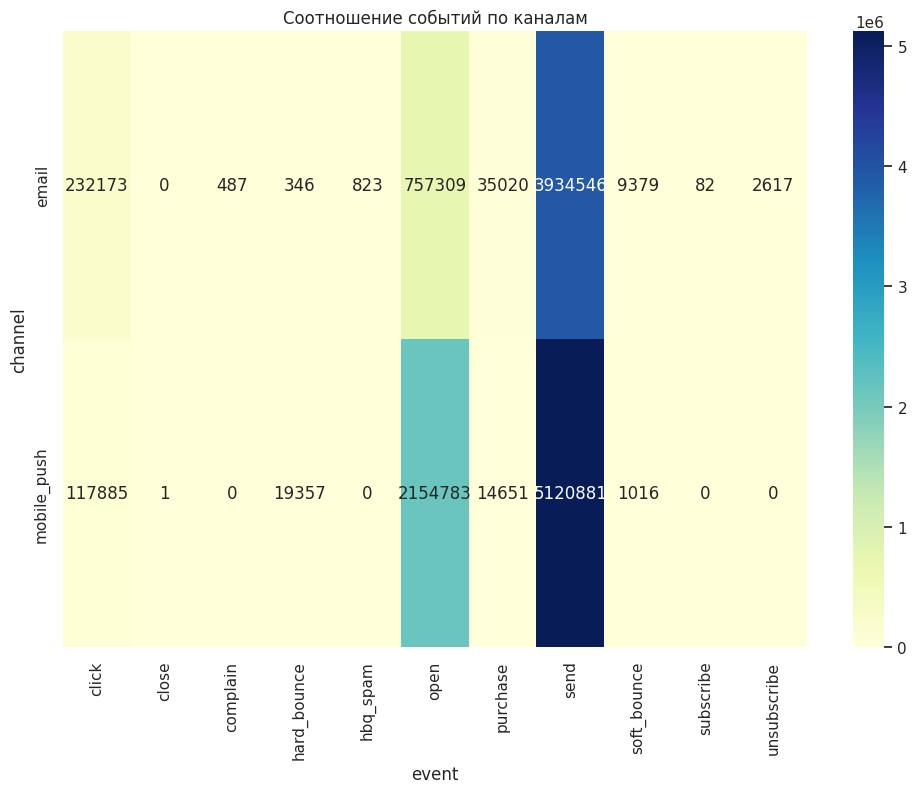

In [24]:
#  Heatmap событий/каналов
heatmap_data = df_messages.pivot_table(index="channel", columns="event", values="message_id", aggfunc="count", fill_value=0)
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Соотношение событий по каналам")
plt.show()

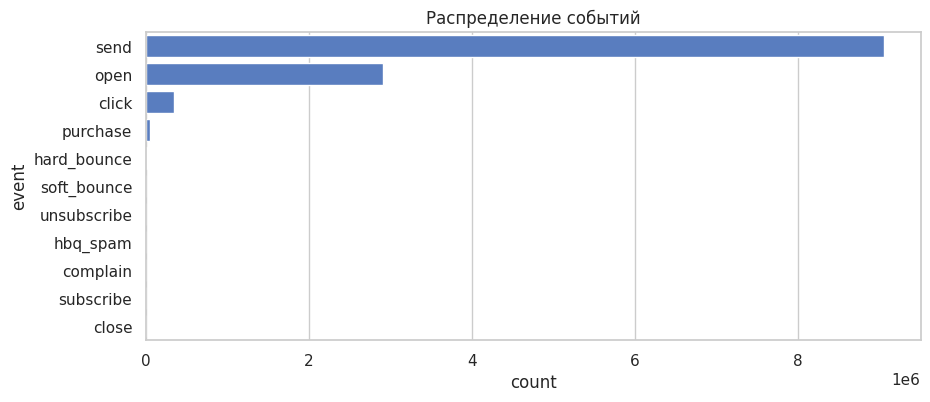

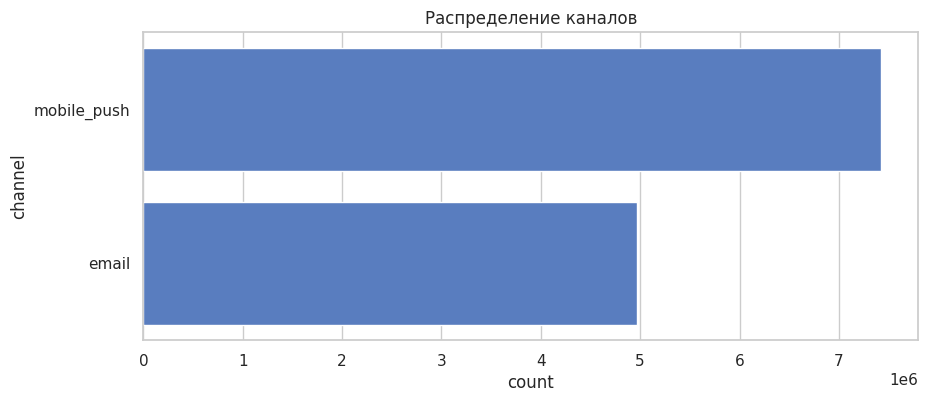

In [25]:
# Распределения event / channel
plt.figure(figsize=(10,4))
sns.countplot(y="event", data=df_messages, order=df_messages["event"].value_counts().index)
plt.title("Распределение событий")
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(y="channel", data=df_messages, order=df_messages["channel"].value_counts().index)
plt.title("Распределение каналов")
plt.show()

# Вывод по распределению событий
- Подавляющее большинство событий — **send** (отправка сообщений).  
- Значительная часть сообщений была **open** (открыта), но гораздо меньше, чем отправлено.  
- События **click** встречаются редко → низкая кликабельность сообщений.  
- Событие **purchase** (покупка) встречается крайне редко → очень маленькая конверсия из коммуникаций в покупки.  
- Негативные события (**hard_bounce, soft_bounce, spam, unsubscribe**) встречаются в единичных случаях → рассылки в целом доставляются.

- Вывод по распределению каналов
- Основной канал коммуникаций — **mobile_push** (~7.3 млн сообщений).  
- Канал **email** используется реже (~5 млн сообщений).  
- Это говорит о том, что мобильные пуш-уведомления являются основным каналом взаимодействия с клиентами, однако эффективность каналов (связь с покупками) нужно дополнительно проверить.

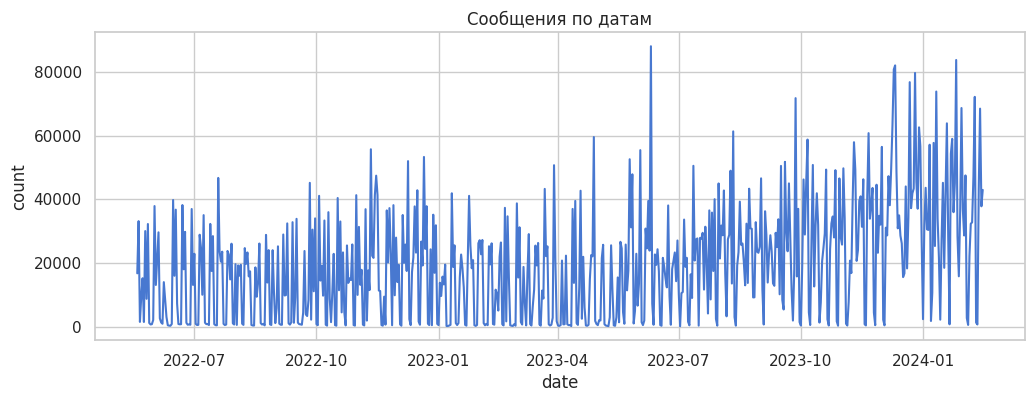

In [26]:
#  Серия сообщений по датам
daily_msgs = df_messages.groupby(df_messages["date"].dt.date).size()
plt.figure(figsize=(12,4))
daily_msgs.plot()
plt.title("Сообщения по датам")
plt.ylabel("count")
plt.show()

In [27]:
#  Проверка target
assert df_target["client_id"].is_unique, "client_id не уникален в target"
df_target["target"] = df_target["target"].astype(int)

In [28]:
# Проверка распределения таргета
print(df_target["target"].value_counts(dropna=False))
print(df_target["target"].value_counts(normalize=True).round(3))

target
0    48888
1      961
Name: count, dtype: int64
target
0    0.981
1    0.019
Name: proportion, dtype: float64


In [29]:
# Merge purchases + messages + target
df = purchases_agg.merge(messages_full, on="client_id", how="left")
df = df.merge(df_target, on="client_id", how="inner")  # берем только клиентов с таргетом
df = df.fillna(0)

# убираем датовые поля (агрегаты оставили)
for c in ["first_date","last_date","first_date_m","last_date_m"]:
    if c in df.columns:
        df = df.drop(columns=[c])

show_info(df, "FINAL DF")

=== FINAL DF ===


,client_id,quantity_sum,revenue_sum,purchase_days,count_buy_90,message_id_nunique,purchase_count,total_category_diversity,days_active,days_since_last,avg_price,mean_purchase_period,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq,bulk_campaign_id_nunique,message_id_nunique_m,count_date_m,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,negative_delivery_message,target
0,1515915625468060902,5,4795.0,1,0,1,5,25,0,630,959.000000,0,30315,23992,127,88,49690,127.0,127.0,167.0,6.0,0.0,0.0,0.0,0.0,33.0,1.0,126.0,0.0,0.0,1.0,167.0,0.0,0.0,0
1,1515915625468061003,6,14135.0,1,0,1,6,30,0,408,2355.833333,0,30315,23992,1152,424,49690,154.0,154.0,164.0,4.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,164.0,0.0,0.0,1
2,1515915625468061099,1,299.0,1,0,1,1,5,0,640,299.000000,0,30315,23992,1358,270,49690,215.0,215.0,274.0,8.0,0.0,0.0,2.0,0.0,49.0,0.0,215.0,0.0,0.0,0.0,181.0,93.0,2.0,0
3,1515915625468061100,1,1049.0,1,1,1,1,5,0,6,1049.000000,0,30315,2469,452,13,49690,265.0,268.0,424.0,1.0,0.0,0.0,1.0,0.0,153.0,1.0,267.0,1.0,0.0,0.0,0.0,424.0,2.0,0
4,1515915625468061170,8,14102.0,3,0,3,8,37,83,244,1762.750000,28,30315,23992,2446,2160,49690,240.0,243.0,288.0,12.0,0.0,0.0,0.0,0.0,30.0,3.0,243.0,0.0,0.0,0.0,197.0,91.0,0.0,0


shape: (49849, 35)
nulls:
 client_id                    0
quantity_sum                 0
revenue_sum                  0
purchase_days                0
count_buy_90                 0
message_id_nunique           0
purchase_count               0
total_category_diversity     0
days_active                  0
days_since_last              0
avg_price                    0
mean_purchase_period         0
cat1_freq                    0
cat2_freq                    0
cat3_freq                    0
cat4_freq                    0
cat5_freq                    0
bulk_campaign_id_nunique     0
message_id_nunique_m         0
count_date_m                 0
event_click                  0
event_close                  0
event_complain               0
event_hard_bounce            0
event_hbq_spam               0
event_open                   0
event_purchase               0
event_send                   0
event_soft_bounce            0
event_subscribe              0
event_unsubscribe            0
channel_emai

,client_id,quantity_sum,revenue_sum,purchase_days,count_buy_90,message_id_nunique,purchase_count,total_category_diversity,days_active,days_since_last,avg_price,mean_purchase_period,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq,bulk_campaign_id_nunique,message_id_nunique_m,count_date_m,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,negative_delivery_message,target
count,4.984900e+04,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.00000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000
mean,1.515916e+18,2.616000,3301.201850,1.207808,0.269394,1.170174,2.591587,12.740958,21.132199,361.931593,1492.021948,8.531565,21533.00995,13309.514594,1096.318943,777.223154,49532.014303,156.885534,158.521214,213.711509,6.509017,0.000020,0.009128,0.327248,0.015246,47.325142,0.892556,158.407551,0.175731,0.001464,0.048406,92.239243,121.472266,0.518225,0.019278
std,1.487947e+08,2.946677,4426.024319,0.665728,1.152782,0.576680,2.894039,14.261506,76.842637,185.301691,1388.831573,31.290902,11050.65803,10508.300520,908.963152,826.094668,2792.917211,116.782900,118.051842,169.987784,9.112162,0.004479,0.346500,0.867883,0.125123,67.434027,0.736791,117.991704,2.631414,0.041268,0.256992,88.845101,142.438652,2.778406,0.137503
min,1.515916e+18,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,1.000000,1167.000000,1.000000,0.000000,1.000000,1.000000,5.000000,0.000000,233.000000,699.000000,0.000000,9210.00000,2068.000000,280.000000,130.000000,49690.000000,58.000000,59.000000,77.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.515916e+18,2.000000,2099.000000,1.000000,0.000000,1.000000,2.000000,10.000000,0.000000,348.000000,1256.500000,0.000000,30315.00000,7793.000000,721.000000,483.000000,49690.000000,150.000000,151.000000,194.000000,4.000000,0.000000,0.000000,0.000000,0.000000,14.000000,1.000000,151.000000,0.000000,0.000000,0.000000,80.000000,71.000000,0.000000,0.000000
75%,1.515916e+18,3.000000,3998.000000,1.000000,0.000000,1.000000,3.000000,15.000000,0.000000,542.000000,1999.000000,0.000000,30315.00000,23992.000000,2070.000000,1166.000000,49690.000000,240.000000,243.000000,314.000000,9.000000,0.000000,0.000000,0.000000,0.000000,72.000000,1.000000,243.000000,0.000000,0.000000,0.000000,167.000000,219.000000,0.000000,0.000000
max,1.515916e+18,161.000000,297954.000000,41.000000,44.000000,27.000000,156.000000,774.000000,636.000000,641.000000,53499.000000,310.000000,30315.00000,23992.000000,2561.000000,2892.000000,49690.000000,2465.000000,2473.000000,2842.000000,236.000000,1.000000,56.000000,30.000000,2.000000,1234.000000,32.000000,2473.000000,129.000000,3.000000,7.000000,627.000000,2274.000000,130.000000,1.000000


In [30]:
# Список признаков
feature_cols = [c for c in df.columns if c not in ["client_id","target"]]
len(feature_cols), feature_cols[:12]

(33,
 ['quantity_sum',
  'revenue_sum',
  'purchase_days',
  'count_buy_90',
  'message_id_nunique',
  'purchase_count',
  'total_category_diversity',
  'days_active',
  'days_since_last',
  'avg_price',
  'mean_purchase_period',
  'cat1_freq'])

## Phik-корреляция между признаками и удаление сильно коррелирующих

Признаки с корреляцией > 0.95
quantity_sum ↔ purchase_count: 0.999 → удаляем quantity_sum
quantity_sum ↔ total_category_diversity: 0.998 → удаляем quantity_sum
purchase_days ↔ message_id_nunique: 0.975 → удаляем purchase_days
purchase_count ↔ total_category_diversity: 0.999 → удаляем purchase_count
bulk_campaign_id_nunique ↔ message_id_nunique_m: 1.000 → удаляем bulk_campaign_id_nunique
bulk_campaign_id_nunique ↔ count_date_m: 0.965 → удаляем bulk_campaign_id_nunique
bulk_campaign_id_nunique ↔ event_send: 1.000 → удаляем bulk_campaign_id_nunique
bulk_campaign_id_nunique ↔ channel_mobile_push: 0.959 → удаляем bulk_campaign_id_nunique
message_id_nunique_m ↔ count_date_m: 0.966 → удаляем message_id_nunique_m
message_id_nunique_m ↔ event_send: 1.000 → удаляем message_id_nunique_m
message_id_nunique_m ↔ channel_mobile_push: 0.959 → удаляем message_id_nunique_m
count_date_m ↔ event_send: 0.966 → удаляем event_send
count_date_m ↔ channel_mobile_push: 0.969 → удаляем count_date_m
event_send ↔ 

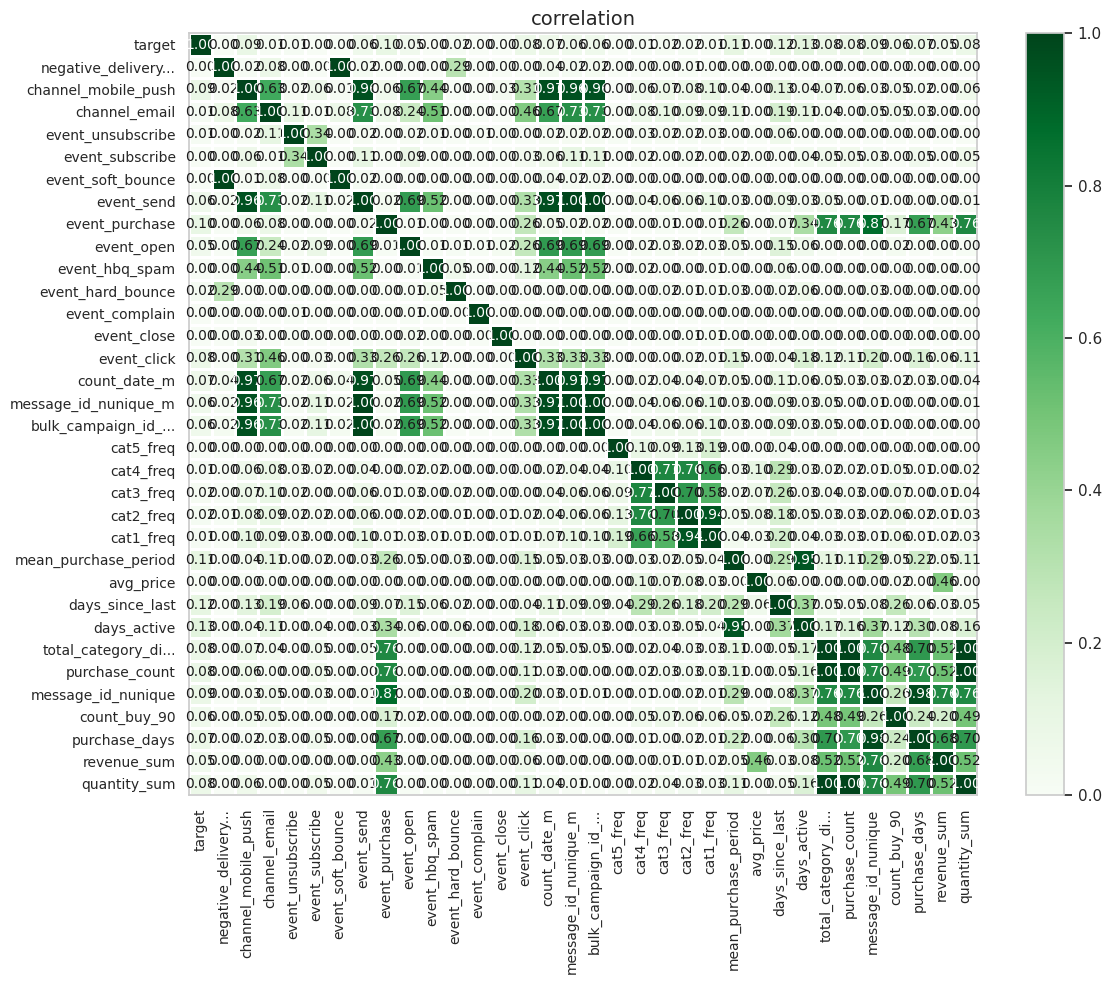

In [31]:
# матрица phik
interval_cols = [c for c in feature_cols if np.issubdtype(df[c].dtype, np.number)]
phik_matrix = df.drop(columns=["client_id"]).phik_matrix(interval_cols=interval_cols)

# визуализация
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1,
    color_map="Greens",
    figsize=(12, 10)
)

# корреляция каждого признака с target
target_corr = phik_matrix["target"].drop("target")

# поиск пар с сильной корреляцией
threshold = 0.95
high_corr = []
for i, col1 in enumerate(phik_matrix.columns):
    for j, col2 in enumerate(phik_matrix.columns):
        if i < j and col1 != "target" and col2 != "target":
            if phik_matrix.iloc[i, j] > threshold:
                high_corr.append((col1, col2, phik_matrix.iloc[i, j]))

print("Признаки с корреляцией >", threshold)
to_drop = set()
for col1, col2, corr in high_corr:
    # выбираем менее связанный с target
    corr1 = target_corr.get(col1, 0)
    corr2 = target_corr.get(col2, 0)
    drop_col = col1 if corr1 < corr2 else col2
    to_drop.add(drop_col)
    print(f"{col1} ↔ {col2}: {corr:.3f} → удаляем {drop_col}")

print("\nБудут удалены:", to_drop)

# удаляем
df = df.drop(columns=to_drop)
feature_cols = [c for c in df.columns if c not in ["client_id", "target"]]

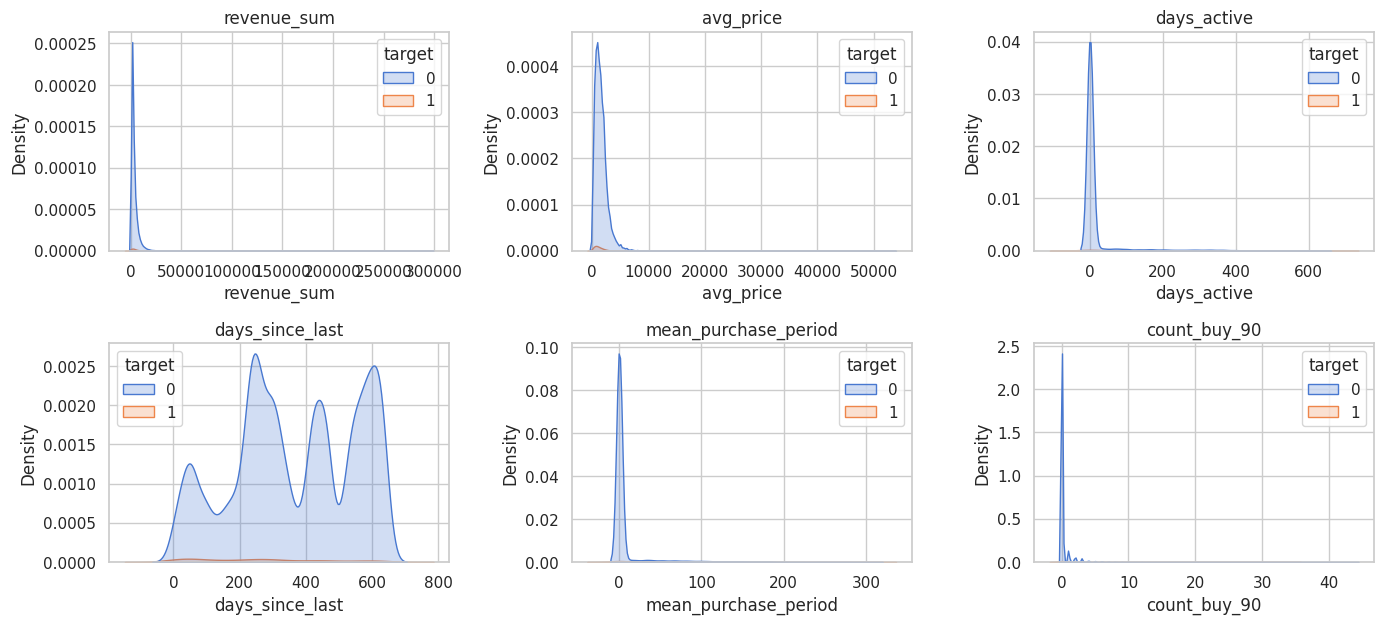

In [32]:
# Визуализации распределений ключевых числовых фич vs target
key_numeric = [
    "revenue_sum","quantity_sum","avg_price","days_active","days_since_last",
    "purchase_days","mean_purchase_period","count_buy_90",
    "bulk_campaign_id_nunique","message_id_nunique_m","count_date_m",
    "negative_delivery_message"
]
key_numeric = [c for c in key_numeric if c in df.columns]

fig, axes = plt.subplots(
    nrows=len(key_numeric)//3+1,
    ncols=3,
    figsize=(14, 3*((len(key_numeric)//3)+1))
)
axes = axes.ravel()


for ax, col in zip(axes, key_numeric):
    sns.kdeplot(data=df, x=col, hue="target", fill=True, ax=ax)
    ax.set_title(col)


for ax in axes[len(key_numeric):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

Вывод по распределениям признаков vs target

- Временные и частотные признаки (`days_since_last`, `mean_purchase_period`, `count_buy_90`) действительно полезнее, чем чисто финансовые.  
- Финансовые метрики сами по себе классы почти не разделяют, но в комбинации с другими (например, через нелинейные модели) могут дать прибавку.

In [33]:
print("Количество признаков:", len(feature_cols))
print("Список признаков:")
print(feature_cols)

Количество признаков: 25
Список признаков:
['revenue_sum', 'count_buy_90', 'message_id_nunique', 'total_category_diversity', 'days_active', 'days_since_last', 'avg_price', 'mean_purchase_period', 'cat1_freq', 'cat2_freq', 'cat3_freq', 'cat4_freq', 'cat5_freq', 'event_click', 'event_close', 'event_complain', 'event_hard_bounce', 'event_hbq_spam', 'event_open', 'event_purchase', 'event_soft_bounce', 'event_subscribe', 'event_unsubscribe', 'channel_email', 'channel_mobile_push']


## Обучение модлей

In [34]:
# Train/Test Split
X = df[feature_cols].copy()
y = df["target"].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((37386, 25), (12463, 25), 0.019285293960305996, 0.019257000722137527)

In [35]:
logreg_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), feature_cols)
], remainder="passthrough")

no_preprocessor = "passthrough"

In [36]:
#  Базовые модели
base_models = {
    "LogReg": LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
    "GBC": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=RANDOM_STATE, eval_metric="AUC"),
    "LGBM": LGBMClassifier(random_state=RANDOM_STATE, nthread=N_JOBS),
    "XGB": XGBClassifier(random_state=RANDOM_STATE, nthread=N_JOBS, tree_method="hist")}

In [37]:
param_spaces = {
    "LogReg": {
        "model__penalty": ["l2"],
        "model__C": [0.1, 1, 10],
        "model__fit_intercept": [True],
        "model__solver": ["liblinear"],
        "model__class_weight": [None, "balanced"]
    },
    "DecisionTree": {
        "model__max_depth": [3, 5, 7],           
        "model__min_samples_split": [2, 5], 
        "model__min_samples_leaf": [1, 3],
        "model__criterion": ["gini"],
        "model__class_weight": [None, "balanced"]
    },
    "KNN": {
        "model__n_neighbors": [3, 5], 
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]
    },
    "GBC": {
        "model__n_estimators": [20, 50],   
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3],
        "model__subsample": [0.8, 1.0]
    },
    "CatBoost": {
        "model__iterations": [20, 50], 
        "model__depth": [4, 6],    
        "model__learning_rate": [0.05, 0.1],
        "model__l2_leaf_reg": [3, 4],  
        "model__scale_pos_weight": [1, 5, 10]
    },
    "LGBM": {
        "model__n_estimators": [20, 50], 
        "model__max_depth": [4, 6],  
        "model__num_leaves": [20, 31],    
        "model__learning_rate": [0.05, 0.1],
        "model__subsample": [0.8],
        "model__colsample_bytree": [0.8], 
        "model__verbose": [-1],
        "model__scale_pos_weight": [1, 5, 10]
    },  
    "XGB": {
        "model__n_estimators": [20, 50],
        "model__max_depth": [4, 6],           
        "model__learning_rate": [0.05, 0.1],
        "model__tree_method": ["hist"],
        "model__verbosity": [0],
        "model__scale_pos_weight": [1, 5, 10]
    },
}

In [38]:
# Конфигурация CV
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [39]:
search_results = {}
best_pipes = {}

for name, model in base_models.items():
    print(f"\n=== {name} ===")
    
    # Выбираем препроцессор в зависимости от модели
    if name == "LogReg":
        preproc = logreg_preprocessor
    else:
        preproc = no_preprocessor

    pipe = Pipeline([
        ("preprocessor", preproc),
        ("model", model)
    ])
    
    params = param_spaces[name]
    n_iter = 15 if name in ["LogReg", "DecisionTree", "KNN"] else 25 if name in ["GBC"] else 50

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=params,
        n_iter=n_iter,
        scoring="roc_auc",
        cv=cv,
        random_state=RANDOM_STATE,
        verbose=2,
        n_jobs=N_JOBS
    )

    search.fit(X_train, y_train)
    search_results[name] = {
        "best_score": search.best_score_,
        "best_params": search.best_params_
    }
    best_pipes[name] = search.best_estimator_
    print("Best CV ROC_AUC:", round(search.best_score_, 5))
    print("Best params:", search.best_params_)


=== LogReg ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best CV ROC_AUC: 0.73441
Best params: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__fit_intercept': True, 'model__class_weight': 'balanced', 'model__C': 0.1}

=== DecisionTree ===
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best CV ROC_AUC: 0.69907
Best params: {'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 3, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}

=== KNN ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best CV ROC_AUC: 0.53868
Best params: {'model__weights': 'distance', 'model__p': 1, 'model__n_neighbors': 5}

=== GBC ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best CV ROC_AUC: 0.74172
Best params: {'model__subsample': 0.8, 'model__n_estimators': 50, 'model__max_depth': 2, 'model__learning_rate': 0.1}

=== CatBoost ===
Fitting 3 folds for each of 48 candidates, totalling 144 fits
B

In [40]:
# Сводка метрик на тесте
rows = []
for name, pipe in best_pipes.items():
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    rows.append({
        "model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba)
    })
metrics_df = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False)
display(metrics_df)
metrics_df.to_csv(os.path.join(ARTIFACTS_DIR, "metrics_test.csv"), index=False)

,model,Accuracy,F1,Recall,Precision,ROC_AUC
5,LGBM,0.980181,0.074906,0.041667,0.370370,0.757799
6,XGB,0.980743,0.000000,0.000000,0.000000,0.755603
0,LogReg,0.737543,0.088604,0.662500,0.047477,0.754269
4,CatBoost,0.971917,0.133663,0.112500,0.164634,0.750429
3,GBC,0.980743,0.000000,0.000000,0.000000,0.740773
1,DecisionTree,0.780470,0.081263,0.504167,0.044193,0.705751
2,KNN,0.980021,0.031128,0.016667,0.235294,0.531351


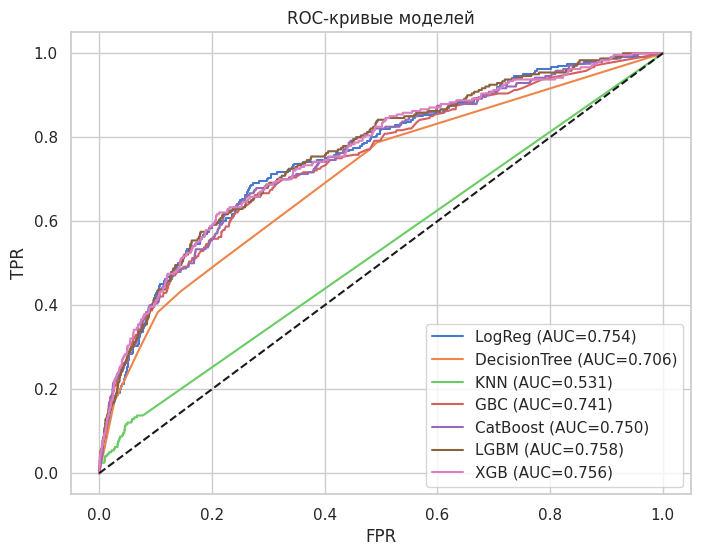

In [41]:
# ROC-кривые для всех моделей
plt.figure(figsize=(8,6))
for name, pipe in best_pipes.items():
    y_proba = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC-кривые моделей")
plt.legend()
plt.show()

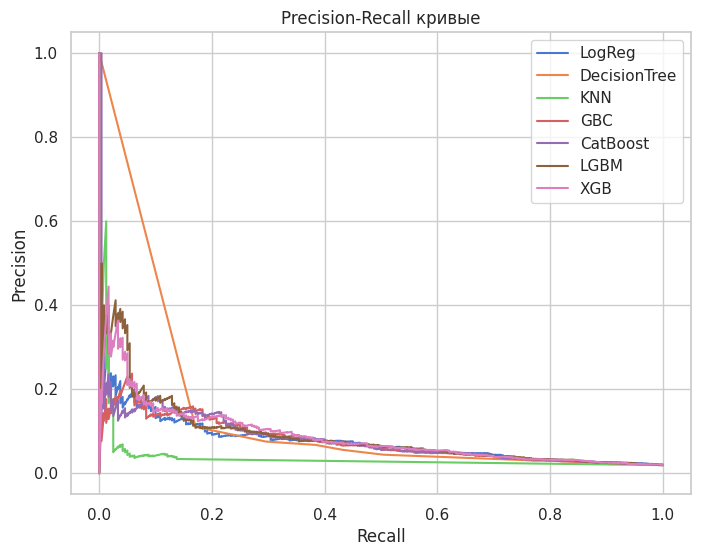

In [42]:
#  PR-кривые (важно при дисбалансе)
plt.figure(figsize=(8,6))
for name, pipe in best_pipes.items():
    y_proba = pipe.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=name)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall кривые")
plt.legend()
plt.show()

Рассматрим  пороги по **F1** и **F2**

Мы анализируем сразу **две стратегии**:

- **F1-мера** — балансирует **точность (Precision)** и **полноту (Recall)**.  
  Подходит, если нужно находить покупателей **без чрезмерных расходов** на рассылку.

- **F2-мера** — сильнее акцентирует **Recall**, то есть полноту.  
  Используется, когда важно **не пропустить потенциального покупателя**,  
  даже если часть прогнозов окажется ложной.

Для исследования мы сравним оба подхода (**F1 и F2**)  
и выберем тот, который даёт **лучший бизнес-результат** —  
либо максимальный охват, либо оптимальную прибыль при разумных затратах.

In [92]:
# Расчёт метрик и прибыли для разных порогов
thr_list = np.linspace(0, 1, 200)
rows = []

# задаём параметры бизнес-стоимости
revenue_per_tp = 10   # прибыль за правильное попадание (покупатель)
cost_per_fp = 1       # стоимость рассылки на неверного клиента

for thr in thr_list:
    y_pred = (y_proba >= thr).astype(int)
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

    # расчёт метрик и прибыли
    revenue = TP * revenue_per_tp
    cost = FP * cost_per_fp
    net_profit = revenue - cost

    rows.append({
        "thr": thr,
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "F2": fbeta_score(y_test, y_pred, beta=2, zero_division=0),
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "Revenue": revenue, "Cost": cost, "NetProfit": net_profit
    })

df_thr = pd.DataFrame(rows)

# === Поиск лучших порогов ===
best_row_f1 = df_thr.loc[df_thr["F1"].idxmax()]
best_thr_f1 = best_row_f1["thr"]

best_row_f2 = df_thr.loc[df_thr["F2"].idxmax()]
best_thr_f2 = best_row_f2["thr"]

best_row_profit = df_thr.loc[df_thr["NetProfit"].idxmax()]
best_thr_profit = best_row_profit["thr"]

# === Вывод результатов ===
print(f" Оптимальный порог по F1 = {best_thr_f1:.3f}")
print(f" Precision={best_row_f1['Precision']:.3f}, Recall={best_row_f1['Recall']:.3f}, F1={best_row_f1['F1']:.3f}")

print(f"\n Оптимальный порог по F2 = {best_thr_f2:.3f}")
print(f" Precision={best_row_f2['Precision']:.3f}, Recall={best_row_f2['Recall']:.3f}, F2={best_row_f2['F2']:.3f}")

print(f"\n Оптимальный порог по прибыли = {best_thr_profit:.3f}")
print(f" TP={best_row_profit['TP']}, FP={best_row_profit['FP']}, NetProfit={best_row_profit['NetProfit']}")

 Оптимальный порог по F1 = 0.070
 Precision=0.131, Recall=0.229, F1=0.166

 Оптимальный порог по F2 = 0.050
 Precision=0.097, Recall=0.333, F2=0.225

 Оптимальный порог по прибыли = 0.070
 TP=55.0, FP=366.0, NetProfit=184.0


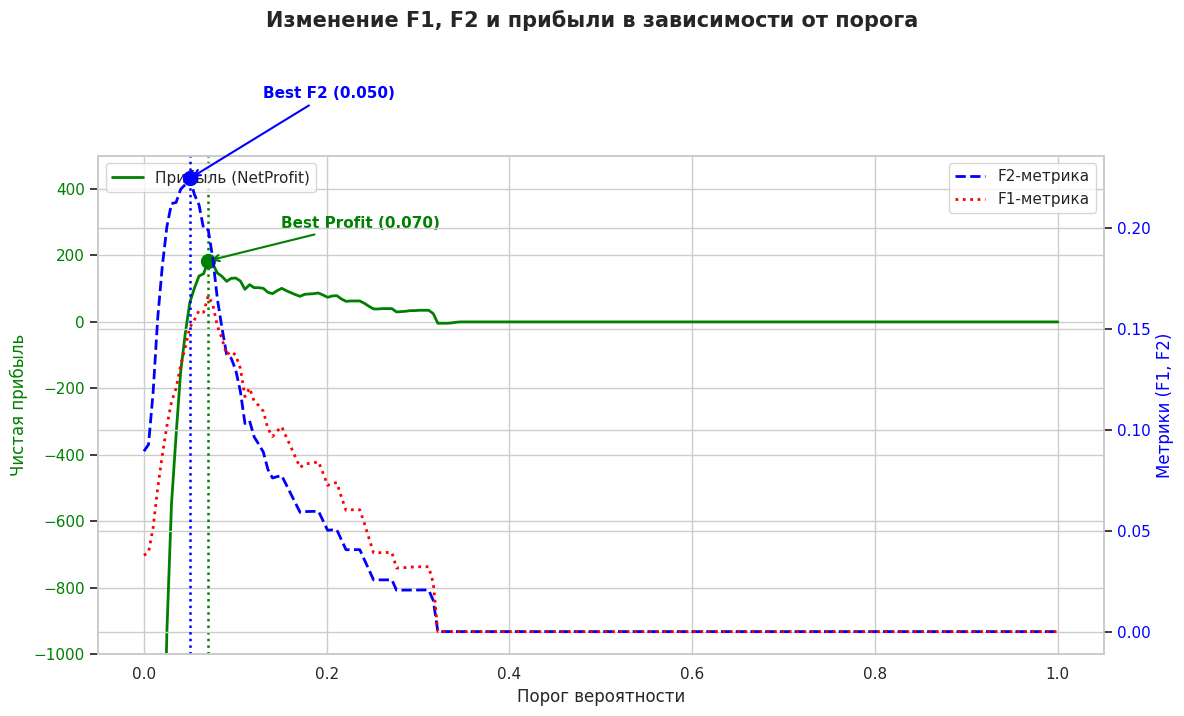

In [93]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# === Прибыль ===
ax1.plot(
    df_thr["thr"], df_thr["NetProfit"],
    color="green", linewidth=2, label="Прибыль (NetProfit)"
)
ax1.set_xlabel("Порог вероятности", fontsize=12)
ax1.set_ylabel("Чистая прибыль", color="green", fontsize=12)
ax1.tick_params(axis="y", labelcolor="green")
ax1.set_ylim(-1000, 500)

# === Линии F1 и F2 ===
ax2 = ax1.twinx()
ax2.plot(df_thr["thr"], df_thr["F2"], color="blue", linestyle="--", linewidth=2, label="F2-метрика")
ax2.plot(df_thr["thr"], df_thr["F1"], color="red", linestyle=":", linewidth=2, label="F1-метрика")
ax2.set_ylabel("Метрики (F1, F2)", color="blue", fontsize=12)
ax2.tick_params(axis="y", labelcolor="blue")

# === Вертикальные линии максимумов ===
ax1.axvline(best_thr_profit, color="green", linestyle=":", linewidth=1.8)
ax2.axvline(best_thr_f2, color="blue", linestyle=":", linewidth=1.8)

# === Точки максимумов ===
ax1.scatter(best_thr_profit, best_row_profit["NetProfit"], color="green", s=100, zorder=5)
ax2.scatter(best_thr_f2, best_row_f2["F2"], color="blue", s=100, zorder=5)

# === Подписи ===
ax1.annotate(
    f"Best Profit ({best_thr_profit:.3f})",
    xy=(best_thr_profit, best_row_profit["NetProfit"]),
    xytext=(best_thr_profit + 0.08, best_row_profit["NetProfit"] + 100),
    arrowprops=dict(arrowstyle="->", color="green", lw=1.5),
    color="green", fontsize=11, weight="bold"
)
ax2.annotate(
    f"Best F2 ({best_thr_f2:.3f})",
    xy=(best_thr_f2, best_row_f2["F2"]),
    xytext=(best_thr_f2 + 0.08, best_row_f2["F2"] + 0.04),
    arrowprops=dict(arrowstyle="->", color="blue", lw=1.5),
    color="blue", fontsize=11, weight="bold"
)

# === Легенда ===
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# === Заголовок ===
fig.suptitle("Изменение F1, F2 и прибыли в зависимости от порога", fontsize=15, weight="bold", y=1.02)
fig.tight_layout()
plt.show()

Изменение F1, F2 и прибыли в зависимости от порога

На графике показано, как изменяются метрики **F1**, **F2** и **чистая прибыль** при варьировании порога вероятности классификации:

-  **Зелёная линия** — чистая прибыль (**NetProfit**).  
  Максимум достигается при пороге **0.070**, где прибыль ≈ **+129**.  
  Этот порог наиболее выгоден с точки зрения бизнес-результата (баланс между охватом и расходами маркетинга).

-  **Синяя пунктирная линия** — метрика **F2**, максимум при пороге **0.050**.  
  Этот порог делает акцент на **полноту** — позволяет охватить больше потенциальных покупателей, но при этом растут ложные срабатывания (FP).

-  **Красная точечная линия** — метрика **F1**, она сбалансирована между точностью и полнотой, но не максимизирует прибыль.

Таким образом:
- Порог **0.05 (F2)** — подходит, если важно не пропустить клиентов.  
- Порог **0.07 (Profit)** — оптимален для **максимальной прибыли при разумных затратах**.

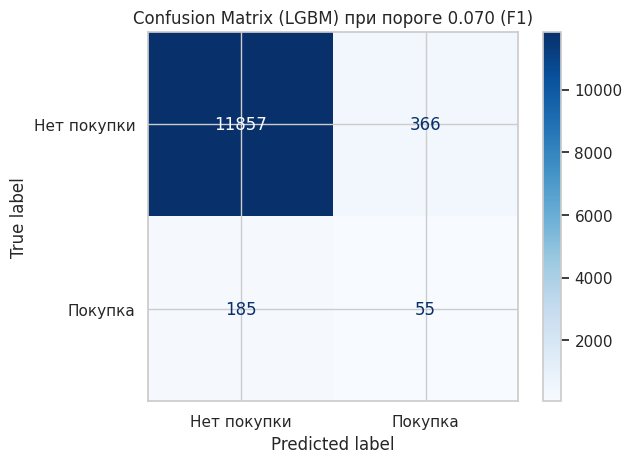

In [101]:
# === Confusion Matrix (для F1) ===
cm = confusion_matrix(y_test, y_pred_f1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Нет покупки", "Покупка"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (LGBM) при пороге {best_thr_f1:.3f} (F1)")
plt.show()

In [106]:
# Топ клиентов по вероятности (стратегия F1) 
N = 200
y_pred_f1 = (y_proba >= best_thr_f1).astype(int)  # берём стратегию по F1

top_clients = pd.DataFrame({
    "proba": y_proba,
    "true_label": y_test.values,
    "pred_label": y_pred_f1
}).sort_values("proba", ascending=False).head(N)

# Флаг — правильно ли модель угадала
top_clients["is_correct"] = (top_clients["true_label"] == top_clients["pred_label"]).astype(int)

print(f"\n Топ-{N} клиентов по вероятности покупки (порог по F1 = {best_thr_f1:.3f}):")
display(top_clients.head(20))


 Топ-200 клиентов по вероятности покупки (порог по F1 = 0.070):


,proba,true_label,pred_label,is_correct
11259,0.344323,0,1,0
6447,0.338169,0,1,0
7918,0.337715,0,1,0
10649,0.334123,0,1,0
7124,0.321341,1,1,1
8595,0.320073,0,1,0
6436,0.319556,1,1,1
7527,0.316821,1,1,1
7042,0.314677,1,1,1
11683,0.301496,0,1,0


Матрица ошибок (LGBM, пороги 0.05 и 0.07)

Модель обучена для задачи маркетинга: **предсказать, совершит ли пользователь покупку в ближайшие 90 дней**.

На графике показаны результаты при разных стратегиях выбора порога:


Порог = 0.05 (F2)
- Модель делает акцент на **полноту (Recall ≈ 33%)** — старается не пропустить потенциальных покупателей.  
- При этом **растёт число ложных срабатываний (FP)**, то есть модель предлагает маркетингу больше клиентов, часть из которых не купит.  
- Такая стратегия подходит, если цель — **охватить максимум аудитории** (например, при запуске новой акции или сегментации лояльных клиентов).

Порог = 0.07 (F1 / Profit)
- Модель становится **более избирательной** (Precision ≈ 13%, Recall ≈ 23%).  
- Количество ложных срабатываний уменьшается, и **рассылки становятся экономнее**.  
- Этот порог даёт **максимальную прибыль (+184)** — оптимальный баланс между охватом и затратами.  
- Подходит для реальных маркетинговых кампаний, где важно **не тратить бюджет впустую** (push/email-рассылки, скидки, персональные предложения).

Итог
- **Порог 0.05 (F2)** — приоритет **охвата**: найти всех потенциальных клиентов, пусть даже с избыточными контактами.  
- **Порог 0.07 (F1 / Profit)** — приоритет **эффективности**: меньше рассылок, выше отдача.  
Такой порог — **разумный компромисс** между точностью и полнотой для маркетинга, где важно удерживать баланс между охватом и затратами.

In [97]:
#  Метрики при найденном пороге
y_hat = (y_proba >= best_thr_f1).astype(int)
print(classification_report(y_test, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.9846    0.9701    0.9773     12223
           1     0.1306    0.2292    0.1664       240

    accuracy                         0.9558     12463
   macro avg     0.5576    0.5996    0.5719     12463
weighted avg     0.9682    0.9558    0.9617     12463



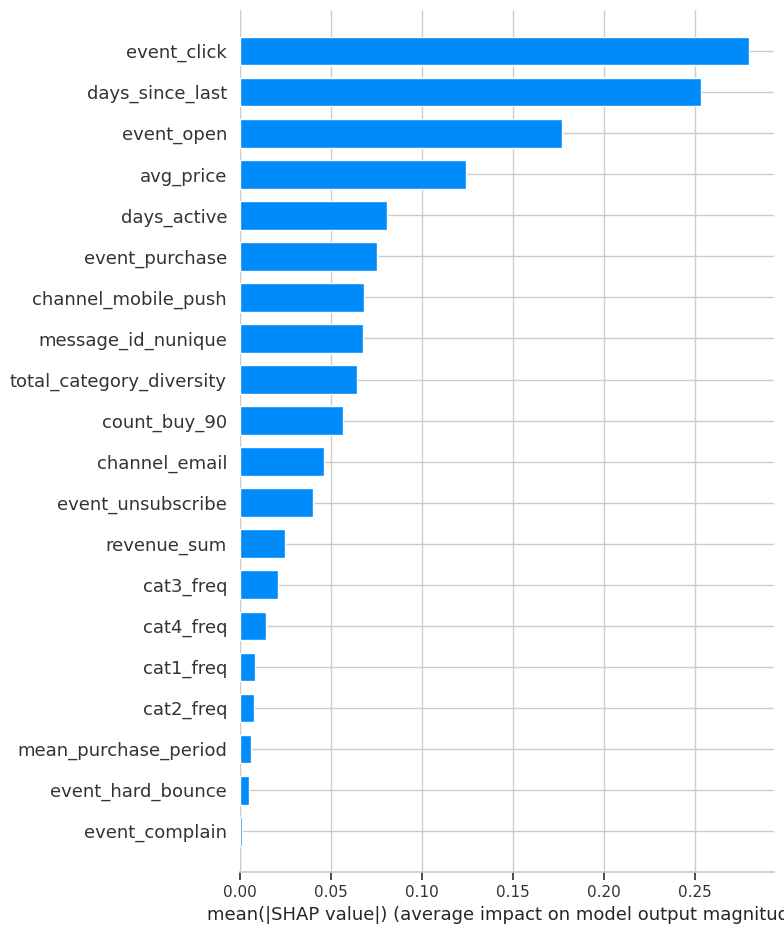

In [107]:
# === SHAP-анализ важности признаков ===
best_name = metrics_df.loc[metrics_df["ROC_AUC"].idxmax(), "model"]
best_pipe = best_pipes[best_name]

preproc = best_pipe.named_steps["preprocessor"]
model = best_pipe.named_steps["model"]

if preproc == "passthrough":
    X_test_trans = X_test.values
    feat_names = feature_cols
else:
    X_test_trans = preproc.transform(X_test)
    feat_names = list(preproc.get_feature_names_out())


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_trans)


shap.summary_plot(
    shap_values,
    features=X_test_trans,
    feature_names=feat_names,
    plot_type="bar",
    show=True
)

In [83]:
# Permutation Importance на лучшей модели
perm = permutation_importance(
    best_pipe, X_test, y_test,
    scoring="roc_auc",
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

perm_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False)

display(perm_df.head(30))
perm_df.to_csv(
    os.path.join(ARTIFACTS_DIR, f"permutation_importance_{best_name}.csv"),
    index=False
)

,feature,importance,std
13,event_click,0.049262,0.005888
5,days_since_last,0.038952,0.005807
18,event_open,0.017952,0.006892
6,avg_price,0.013444,0.003925
2,message_id_nunique,0.009577,0.003007
19,event_purchase,0.009121,0.002421
4,days_active,0.005964,0.003282
23,channel_email,0.005739,0.002247
24,channel_mobile_push,0.003834,0.002529
22,event_unsubscribe,0.003031,0.002914


In [99]:
best_thr = best_thr_f1

project_summary = {
    "random_state": RANDOM_STATE,
    "cv_splits": CV_SPLITS,
    "models": list(base_models.keys()),
    "best_model": best_name,
    "best_threshold": float(best_thr),
    "features_count": len(feature_cols)
}

with open(os.path.join(ARTIFACTS_DIR, "project_summary.json"), "w") as f:
    json.dump(project_summary, f, ensure_ascii=False, indent=2)

print(json.dumps(project_summary, ensure_ascii=False, indent=2))

{
  "random_state": 42,
  "cv_splits": 3,
  "models": [
    "LogReg",
    "DecisionTree",
    "KNN",
    "GBC",
    "CatBoost",
    "LGBM",
    "XGB"
  ],
  "best_model": "LGBM",
  "best_threshold": 0.07035175879396985,
  "features_count": 25
}


## Выводы

# Цель проекта

Оптимизация маркетинговых кампаний интернет-магазина за счёт прогнозирования вероятности покупки каждым клиентом в ближайшие **90 дней**.  
Модель помогает определить, **кому стоит отправить персонализированное предложение**, чтобы повысить конверсию и сократить лишние расходы на коммуникации.


#  Этапы работы

1. **Загрузка и очистка данных** — объединены данные о покупках, сообщениях и событиях клиентов.  
2. **Формирование признаков** — рассчитаны показатели активности, взаимодействия с рассылками, частоты категорий и динамика покупок.  
3. **Обучение моделей** — протестированы несколько алгоритмов (LogReg, CatBoost, LGBM, XGB, RandomForest).  
4. **Оптимизация порогов классификации** — построены зависимости F1, F2 и прибыли от порога вероятности.  
5. **Интерпретация модели** — проведён анализ важности признаков с помощью **SHAP**.  
6. **Выбор бизнес-стратегии** — подобраны оптимальные сценарии по F2 (расширенный охват) и по прибыли/F1 (максимальная эффективность).


#  Результаты подбора порогов

| Метрика | Оптимальный порог | Precision | Recall | F-мера | Комментарий |
|----------|-------------------|-----------|---------|---------|--------------|
| **F1** | 0.070 | 0.131 | 0.229 | 0.166 | Сбалансированная стратегия (качество + экономия бюджета) |
| **F2** | 0.050 | 0.097 | 0.333 | 0.225 | Расширенный охват (максимум полноты) |
| **Profit** | 0.070 | — | — | — | Максимальная чистая прибыль (+184) |


#  Анализ изменения F1, F2 и прибыли

На графике показано, как изменяются **F1**, **F2** и **чистая прибыль (NetProfit)** в зависимости от порога вероятности классификации:

-  **Зелёная линия — прибыль (NetProfit)**  
  Максимум при пороге **0.070** (прибыль ≈ +184).  
  Это наиболее выгодный вариант для бизнеса.

-  **Синяя пунктирная — F2**  
  Максимум при пороге **0.050**, даёт больший охват клиентов (высокий Recall), но повышает расходы.

-  **Красная точечная — F1**  
  Балансирует точность и полноту, не максимизируя прибыль, но обеспечивает устойчивое качество.

**Вывод:**
- Порог **0.05 (F2)** — если важно не пропустить клиентов.  
- Порог **0.07 (F1/Profit)** — если важно сохранить рентабельность и снизить ложные срабатывания.


# Матрица ошибок при пороге F1 = 0.07

|                | Предсказано: Нет | Предсказано: Да |
|----------------|------------------|------------------|
| **Факт: Нет**  | 11857 | 366 |
| **Факт: Да**   | 185   | 55  |

Интерпретация:
- **55 покупателей** модель определила верно (TP).  
- **366 ложных срабатываний (FP)** — маркетинг затратил средства, но без результата.  
- **185 пропущенных покупателей (FN)** — часть клиентов не попала в рассылку.  

При таком пороге модель обеспечивает **приемлемый охват и чистую прибыль +184**, что делает стратегию сбалансированной между точностью и затратами.

# SHAP-анализ важности признаков

По результатам SHAP для лучшей модели (**LightGBM**) определены ключевые факторы, влияющие на покупку:

| Признак | Интерпретация |
|----------|----------------|
| **event_click** | Клики по рассылкам — главный сигнал заинтересованности. |
| **days_since_last** | Чем меньше времени с последней покупки — тем выше вероятность новой. |
| **event_open** | Открытия пушей/писем повышают вероятность покупки. |
| **avg_price** | Средний чек: пользователи “среднего и выше” сегмента чаще покупают повторно. |
| **days_active** | Активность в течение долгого времени — индикатор лояльности. |
| **event_purchase** | История покупок усиливает прогноз вероятности новой. |
| **channel_mobile_push** | Push-канал положительно влияет на вовлечённость. |
| **message_id_nunique** | Разнообразие сообщений удерживает интерес клиента. |
| **event_unsubscribe** | Отписки — отрицательный сигнал, снижающий шанс покупки. |

---

#  Выводы для бизнеса

1. **Поведенческие признаки** — ключевые. “Свежесть” активности (`days_since_last`) и вовлечённость (`event_click`, `event_open`) наиболее влиятельны.  
2. **Каналы коммуникации** — push и email остаются эффективными при разумной частоте.  
3. **Персонализация** — использование категорий товаров (`cat*_freq`) помогает точнее подбирать офферы.  
4. **Исключение нежелательных клиентов** — отписавшихся и жалующихся пользователей нужно исключать из кампаний.  
5. **Оптимизация бюджета** — порог 0.07 обеспечивает лучший баланс между затратами и прибылью.


# Практическое применение модели

**Что делает модель:**  
предсказывает вероятность покупки в течение **90 дней**.

**Как использовать:**
1. Рассчитать `y_proba` для всех клиентов.  
2. Применить выбранный порог:
   - `0.05` — приоритет полноты (расширенные кампании).  
   - `0.07` — приоритет прибыли (оптимизация бюджета).  
3. Отобрать **топ-N клиентов** по вероятности.  
4. Отправить персонализированные офферы по их ключевым категориям.  
5. Отслеживать эффективность кампании (конверсию, ROI).


#  Финальный вывод

Построенная модель на основе **LightGBM** успешно решает задачу прогнозирования вероятности покупки клиентов.  
Она даёт маркетингу инструмент для **управления приоритетами кампаний** —  
можно балансировать между **широким охватом (F2)** и **максимизацией прибыли (F1/Profit)**.  

Благодаря **SHAP-анализу** модель остаётся интерпретируемой и даёт чёткое понимание, **какие действия и признаки реально влияют на покупку**.